In [47]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, \
    SqrtStretch, AsymmetricPercentileInterval, ManualInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
import sunpy.map
aia_171_cm = plt.get_cmap("sdoaia171")
aia_211_cm = plt.get_cmap("sdoaia211")
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from num2tex import num2tex
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans

In [48]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [49]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [50]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [51]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [52]:
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_63rd.h5", 'r') as hf:
    flatfield_1d_FeXIV_63rd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

In [53]:
with fits.open("../../src/AIA/AIA20170821_174645_0171.fits") as hdul:
    aia_171_header = hdul[0].header
    aia_171_image = np.copy(hdul[0].data)
    aia_171_xcoord = np.linspace(1 - aia_171_header["CRPIX1"],
                        aia_171_header["NAXIS1"] - aia_171_header["CRPIX1"],
                        aia_171_header["NAXIS1"])*aia_171_header["CDELT1"]
    aia_171_ycoord = np.linspace(1 - aia_171_header["CRPIX2"],
                        aia_171_header["NAXIS2"] - aia_171_header["CRPIX2"],
                        aia_171_header["NAXIS2"])*aia_171_header["CDELT2"]
    aia_171_meshy, aia_171_meshx = np.meshgrid(aia_171_ycoord,aia_171_xcoord,indexing="ij")
    aia_171_mask = np.where(np.sqrt(np.square(aia_171_meshy) + np.square(aia_171_meshx)) >= aia_171_header["CDELT1"]*aia_171_header["R_SUN"])
    aia_171_image[aia_171_mask] = np.nan

In [54]:
with fits.open("../../src/AIA/AIA20170821_174645_0211.fits") as hdul:
    aia_211_header = hdul[0].header
    aia_211_image = np.copy(hdul[0].data)
    aia_211_xcoord = np.linspace(1 - aia_211_header["CRPIX1"],
                        aia_211_header["NAXIS1"] - aia_211_header["CRPIX1"],
                        aia_211_header["NAXIS1"])*aia_211_header["CDELT1"]
    aia_211_ycoord = np.linspace(1 - aia_211_header["CRPIX2"],
                        aia_211_header["NAXIS2"] - aia_211_header["CRPIX2"],
                        aia_211_header["NAXIS2"])*aia_211_header["CDELT2"]
    aia_211_meshy, aia_211_meshx = np.meshgrid(aia_211_ycoord,aia_211_xcoord,indexing="ij")
    aia_211_mask = np.where(np.sqrt(np.square(aia_211_meshy) + np.square(aia_211_meshx)) >= aia_211_header["CDELT1"]*aia_211_header["R_SUN"])
    aia_211_image[aia_211_mask] = np.nan

In [55]:
def calculate_intensity(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2):
    image_sliced = image[ypix_slice, wavelength_slice]
    wvl_sliced = wvl[wavelength_slice]
    if ypix_slice.stop is not None:
        intensity_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
        cont_sliced = np.zeros(ypix_slice.stop - ypix_slice.start)
    else:
        intensity_sliced = np.zeros(350)
        cont_sliced = np.zeros(350)
        
    for ii in range(len(intensity_sliced)):
        intensity_sliced[ii], cont_sliced[ii] = calculate_intensity_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:])

    return intensity_sliced, cont_sliced

def fit_spectra(image, wvl, wavelength_slice, ypix_slice, cont_slice_1, cont_slice_2,nbin=5,plot_fit=False):
    image_sliced = image[ypix_slice, wavelength_slice]
    if (nbin == 1) or (nbin is None):
        pass
    else:
        image_sliced = np.average(image_sliced.reshape(-1,nbin,image_sliced.shape[1]),axis=1)
    wvl_sliced = wvl[wavelength_slice]
    fit_params = np.zeros((4,image_sliced.shape[0]))
    fit_errs = np.zeros((4,image_sliced.shape[0]))

    for ii in range(image_sliced.shape[0]):
        fit_params[:,ii], fit_errs[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_sliced[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_sliced[ii,:],
                                plot_fit=plot_fit)

    return fit_params, fit_errs

    
def calculate_intensity_single(cont_wvl, cont_int, wvl, int):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)
    int_sum = np.sum(int_res)

    return int_sum, np.mean(cont_fit_poly(wvl))


def fit_spectra_single(cont_wvl, cont_int, wvl, int,plot_fit=False):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)

    fit_model = SpectrumFitSingle(data=int_res,wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=0.1)

    try:
        fit_model.run_lse()
    except RuntimeError:
        pass
    if plot_fit:
        fit_model.plot(plot_params=False)
        print(fit_model.fwhm_fit)

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0],
                     cont_fit_poly(fit_model.line_wvl_fit[0]) + fit_model.int_cont_fit]), \
            np.array([fit_model.line_wvl_err[0], fit_model.int_total_err[0], fit_model.fwhm_err[0],
                    fit_model.int_cont_err])

In [56]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63rd.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [57]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [58]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [59]:
FeXIV_63rd_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_63rd_xslice])))
inst_width_pix_green = 1.86
inst_width_nm_green = pixel_size_green*inst_width_pix_green

print(pixel_size_green, inst_width_nm_green)

0.024135148361387 0.04489137595217982


In [60]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [61]:
green_mask_bad_fit_matrix_ext = np.where(np.any(np.abs(green_fit_matrix_ext_err/green_fit_matrix_ext) > 0.5,axis=0) | \
                np.any(np.isnan(green_fit_matrix_ext_err),axis=0))
green_mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(green_fit_matrix_bin_ext_err/green_fit_matrix_bin_ext) > 0.2,axis=0) | \
                np.any(np.isnan(green_fit_matrix_bin_ext_err),axis=0))

kernel = Gaussian2DKernel(x_stddev=1,y_stddev=2)
kernel_bin = Gaussian2DKernel(x_stddev=1,y_stddev=0.2)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
green_line_int_masked[green_mask_bad_fit_matrix_ext] = np.nan
green_line_int_masked[green_where_disk_ext] = np.nan
green_line_int_masked = interpolate_replace_nans(green_line_int_masked,kernel)
green_line_int_masked[green_where_disk_ext] = np.nan

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:])
green_cont_masked[green_mask_bad_fit_matrix_ext] = np.nan
green_cont_masked = interpolate_replace_nans(green_cont_masked, kernel)
green_cont_masked[green_where_disk_ext] = np.nan

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/green_fit_matrix_ext[3,:,:]
green_line_cont_ratio_masked[green_mask_bad_fit_matrix_ext] = np.nan
green_line_cont_ratio_masked = interpolate_replace_nans(green_line_cont_ratio_masked,kernel)
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
green_vlos_masked_err = green_fit_matrix_bin_ext_err[0,:,:]/530.29*const.c.cgs.value*1e-5
green_vlos_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked_err[green_where_disk_bin_ext] = np.nan

green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[green_where_disk_bin_ext] = np.nan
green_fwhm_masked_err = np.copy(green_fit_matrix_bin_ext_err[2,:,:])
green_fwhm_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
green_veff_masked_err = green_fwhm_masked/np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)* \
    green_fwhm_masked_err/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


In [83]:
def spectral_line_zoom_in(solarx,solary,fig,ax,rect,anchor_point,
    x_grid_bin, y_grid_bin,
    file_grid, path, file_df,wvl_slice,flatfield_1d,order,
    fit_bin_matrix, fit_bin_matrix_err,
    vlos_masked,vlos_masked_err,veff_masked,veff_masked_err,
    cont_slice_1 = slice(0,10), cont_slice_2 = slice(40,50),
    params_prec = {"int":2,"wvl":1,"fwhm":1}):

    ax_spec = ax.inset_axes(bounds=rect,transform=ax.transAxes)

    con_line = patches.ConnectionPatch(xyA=(solarx,solary),xyB=anchor_point,axesA=ax,axesB=ax_spec,coordsA='data',
                coordsB='axes fraction',color='#CB4042',linewidth=3,alpha=0.7)
    ax.add_artist(con_line)

    y_select_pixel,x_select_pixel = find_nearest_pixel(solarx, solary, 
                x_grid_bin,y_grid_bin)
    solarx_select, solary_select = x_grid_bin[y_select_pixel,x_select_pixel], y_grid_bin[y_select_pixel,x_select_pixel]
    file_index = file_grid[x_select_pixel]
    frame = CCDData.read(os.path.join(path,file_df.iloc[file_index,0]),hdu=0,unit="adu")
    frame_wavelength = CCDData.read(os.path.join(path,file_df.iloc[file_index,0]),hdu=2,unit="adu").data
    frame_wavelength = frame_wavelength/order/10.
    profile_to_fit = frame.data/flatfield_1d[:,np.newaxis]/frame.header["exptime"]
    profile_to_fit = np.flip(profile_to_fit,axis=0)
    profile_to_fit = np.mean(profile_to_fit[y_select_pixel*5:(y_select_pixel+1)*5,wvl_slice],axis=0)
    frame_wavelength_sliced = frame_wavelength[wvl_slice]

    cont_wvl = frame_wavelength_sliced[np.r_[cont_slice_1, cont_slice_2]]
    cont_int = profile_to_fit[np.r_[cont_slice_1, cont_slice_2]]
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    profile_res = profile_to_fit - cont_fit_poly(frame_wavelength_sliced)
    profile_fit = gaussian(frame_wavelength_sliced,*fit_bin_matrix[:3,y_select_pixel,x_select_pixel]) + \
        fit_bin_matrix[3,y_select_pixel,x_select_pixel] - np.mean(cont_fit_poly(frame_wavelength_sliced))

    wvl_to_plot = np.linspace(frame_wavelength_sliced[0],frame_wavelength_sliced[-1],301)
    profile_fit_to_plot = gaussian(wvl_to_plot,*fit_bin_matrix[:3,y_select_pixel,x_select_pixel]) + \
        fit_bin_matrix[3,y_select_pixel,x_select_pixel] - np.mean(cont_fit_poly(frame_wavelength_sliced))
    fit_res = profile_res - profile_fit

    plot_xlim = fit_bin_matrix[0,y_select_pixel,x_select_pixel] + \
            3*np.array([-fit_bin_matrix[2,y_select_pixel,x_select_pixel],
                fit_bin_matrix[2,y_select_pixel,x_select_pixel]])

    line_wvl_plot,int_total_plot,fwhm_plot = fit_bin_matrix[:3,y_select_pixel,x_select_pixel]
    line_wvl_err_plot,int_total_err_plot,fwhm_err_plot = fit_bin_matrix_err[:3,y_select_pixel,x_select_pixel]
    vlos_plot, vlos_err_plot = (vlos_masked[y_select_pixel,x_select_pixel], 
                                vlos_masked_err[y_select_pixel,x_select_pixel])
    veff_plot, veff_err_plot = (veff_masked[y_select_pixel,x_select_pixel], 
                                veff_masked_err[y_select_pixel,x_select_pixel])

    int_total_text_fmt = r'$I_0 : {:#.{int_data_prec}g}$' #\pm{:#.{int_err_prec}g}$'
    line_wvl_text_fmt = r'$\lambda_0 : {:#.{wvl_data_prec}g}$' #\pm{:#.{wvl_err_prec}g}$'
    fwhm_text_fmt = r'$\Delta \lambda : {:#.{fwhm_data_prec}g}$' #\pm{:#.{fwhm_err_prec}g}$'
    vlos_text_fmt = r'$v : {:#.{vlos_data_prec}g}$' #\pm{:#.{vlos_err_prec}g}$'
    veff_text_fmt = r'$v_{{\rm eff}} : {:#.{veff_data_prec}g}$' #\pm{:#.{veff_err_prec}g}$'
                    
    
    ax_spec.step(frame_wavelength_sliced,profile_res,where="mid",
                color="#E87A90",label = r"$I_{\rm obs}$",lw=2,zorder=15)
    ax_spec.fill_between(frame_wavelength_sliced,
    np.ones_like(frame_wavelength_sliced)*np.min(profile_res),profile_res,
                step='mid',color="#FEDFE1",alpha=0.6)

    ax_spec.plot(wvl_to_plot,profile_fit_to_plot,color="black",ls="-",label = r"$I_{\rm fit}$",lw=2,
                        zorder=16,alpha=0.7)

    ax_spec.set_xlim(plot_xlim)
    ax_spec.tick_params(labelsize=16)
    ax_spec.text(0.97,0.95,r"{:.2f}\,$R_\odot$".format(np.sqrt(solarx_select**2 + solary_select**2)/950.),fontsize=20,
                transform=ax_spec.transAxes,ha="right",va="top")

    vlos_data_prec = np.ceil(np.log10(np.abs(vlos_plot))).astype("int") - \
        np.ceil(np.log10(vlos_err_plot)).astype("int") + params_prec["wvl"]

    # ax_spec.text(0.03,0.9,vlos_text_fmt.format(num2tex(vlos_plot),
    # num2tex(vlos_err_plot),vlos_data_prec = vlos_data_prec,vlos_err_prec = params_prec["wvl"]),ha = 'left',va = 'center', 
    # color = 'black',fontsize = 16,linespacing=1.5,transform=ax_spec.transAxes)

    ax_spec.text(0.03,0.9,vlos_text_fmt.format(num2tex(vlos_plot),
    vlos_data_prec = vlos_data_prec),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)

    veff_data_prec = np.ceil(np.log10(np.abs(veff_plot))).astype("int") - \
        np.ceil(np.log10(veff_err_plot)).astype("int") + params_prec["fwhm"]

    # ax_spec.text(0.03,0.7,veff_text_fmt.format(num2tex(veff_plot),
    # num2tex(veff_err_plot),veff_data_prec = veff_data_prec,veff_err_prec = params_prec["fwhm"]),ha = 'left',va = 'center', 
    # color = 'black',fontsize = 16,linespacing=1.5,transform=ax_spec.transAxes)

    ax_spec.text(0.03,0.75,veff_text_fmt.format(num2tex(veff_plot),
    veff_data_prec = veff_data_prec),ha = 'left',va = 'center', 
    color = 'black',fontsize = 20,linespacing=1.5,transform=ax_spec.transAxes)
        

    





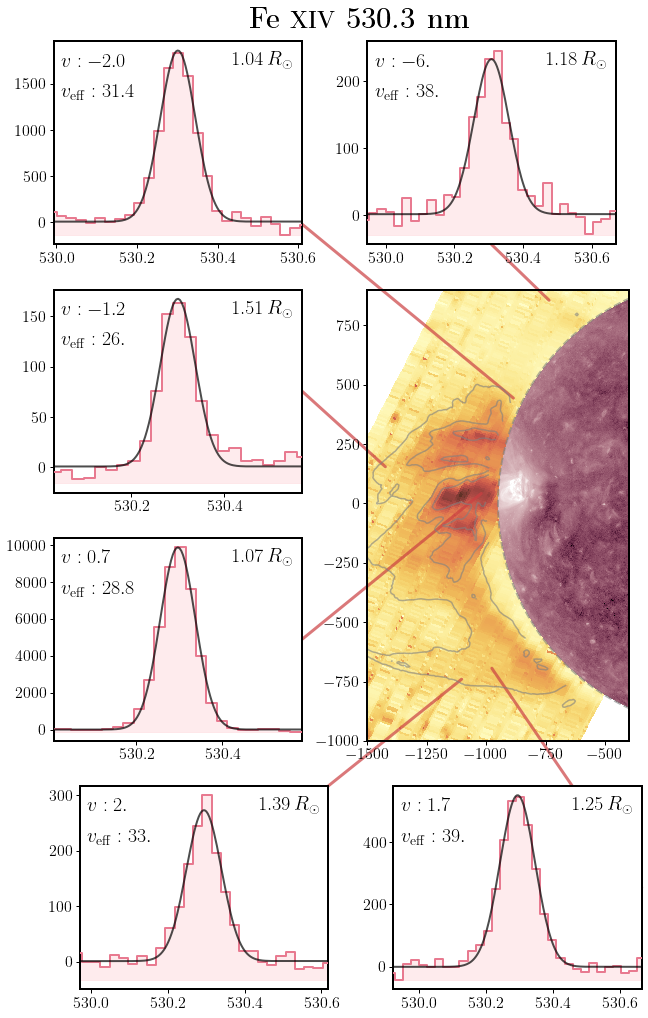

In [89]:
colorbar_width = "5%"


def create_rec_eqs():
    return patches.Rectangle((eis_eqs_xstart, eis_eqs_ystart),
                            eis_eqs_fovx, eis_eqs_fovy,linewidth=2,edgecolor="red",
                            facecolor="none",alpha=0.6)

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

fig, ax = plt.subplots(figsize=(8,8),constrained_layout=True,gridspec_kw={'left':0.4,'top':0.8,'bottom':0.2})
green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                        (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 940**2)

# green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
# green_line_int_masked[green_where_disk_ext] = np.nan
# norm_green_line_int = ImageNormalize(green_line_int_masked,interval=ManualInterval(0,850),
#                                         stretch=SqrtStretch())

im = ax.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.16)

ax.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
                    colors=['grey'])
# plot_colorbar(im, ax,width=colorbar_width,fontsize=16)

norm_aia_211 = ImageNormalize(aia_211_image,interval=AsymmetricPercentileInterval(0.5,99.97),stretch=LogStretch())
ax.pcolormesh(aia_211_xcoord, aia_211_ycoord, aia_211_image,cmap=aia_211_cm,norm=norm_aia_211,
                rasterized=True,shading="auto")



xlim_zoomin = [-1500,-400]
ylim_zoomin = [-1000,900]

ax.set_aspect(1)
# ax.add_patch(create_rec_eqs())
ax.add_patch(create_limb_circle(rsun_arcsec))
ax.set_xlim(xlim_zoomin)
ax.set_ylim(ylim_zoomin)
ax.tick_params(labelsize=16)

feed_params = (x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                        green_fit_filename_index, green_path,
                        totality_green_df_ext,FeXIV_63rd_xslice,flatfield_1d_FeXIV_63rd,63, 
                        green_fit_matrix_bin_ext, green_fit_matrix_bin_ext_err,
                        green_vlos_masked, green_vlos_masked_err, green_veff_masked, green_veff_masked_err)

spectral_line_zoom_in(-1020,42,fig,ax,[-1.2,0,0.95,0.45],(1,0.5),
                        *feed_params)
spectral_line_zoom_in(-1424,154,fig,ax,[-1.2,0.55,0.95,0.45],(1,0.5),
                        *feed_params)
spectral_line_zoom_in(-1103,-740,fig,ax,[-1.1,-0.55,0.95,0.45],(1,1),
                        *feed_params)
spectral_line_zoom_in(-976,-694,fig,ax,[0.1,-0.55,0.95,0.45],(1,0.5),
                        *feed_params)
spectral_line_zoom_in(-885,443,fig,ax,[-1.2,1.1,0.95,0.45],(1,0.1),
                        *feed_params)
spectral_line_zoom_in(-735,855,fig,ax,[0,1.1,0.95,0.45],(0.5,0),
                        *feed_params)
ax.text(-0.45,1.58,r"\textbf{Fe \textsc{xiv} 530.3 nm}",fontsize=30,transform=ax.transAxes)
fig.savefig(fname="../../slides/reg_meet/figs/FeXIV_zoomin.pdf",format="pdf",dpi=300,bbox_inches="tight")
fig.savefig(fname="../../slides/reg_meet/figs/FeXIV_zoomin.png",format="png",dpi=300,bbox_inches="tight")

In [64]:
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeX_52.h5", 'r') as hf:
    red_fit_matrix_ext = hf['red_fit_matrix_ext'][:]
    red_fit_matrix_ext_err = hf['red_fit_matrix_ext_err'][:]
    red_fit_matrix_bin_ext = hf['red_fit_matrix_bin_ext'][:]
    red_fit_matrix_bin_ext_err = hf['red_fit_matrix_bin_ext_err'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]

In [65]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-51,125,1,dtype=np.float64) + 8
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,87.5,176) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

In [66]:
FeX_xslice = slice(602,652)
pixel_size_red = np.abs(np.mean(np.diff((red_frame_wavelength/52/10.)[FeX_xslice])))
inst_width_pix_red = 2.12
inst_width_nm_red = pixel_size_red*inst_width_pix_red

img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

In [67]:
slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [70]:
red_mask_bad_fit_matrix_ext = np.where(np.any(np.abs(red_fit_matrix_ext_err/red_fit_matrix_ext) > 0.5,axis=0) | \
                np.any(np.isnan(red_fit_matrix_ext_err),axis=0))
red_mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(red_fit_matrix_bin_ext_err/red_fit_matrix_bin_ext) > 0.2,axis=0) | \
                np.any(np.isnan(red_fit_matrix_bin_ext_err),axis=0))


red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_mask_bad_fit_matrix_ext] = np.nan
red_line_int_masked[red_where_disk_ext] = np.nan
red_line_int_masked = interpolate_replace_nans(red_line_int_masked,kernel)
red_line_int_masked[red_where_disk_ext] = np.nan

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:])
red_cont_masked[red_mask_bad_fit_matrix_ext] = np.nan
red_cont_masked = interpolate_replace_nans(red_cont_masked, kernel)
red_cont_masked[red_where_disk_ext] = np.nan

red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
red_line_cont_ratio_masked[red_mask_bad_fit_matrix_ext] = np.nan
red_line_cont_ratio_masked = interpolate_replace_nans(red_line_cont_ratio_masked,kernel)
red_line_cont_ratio_masked[red_where_disk_ext] = np.nan

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
red_vlos_masked_err = red_fit_matrix_bin_ext_err[0,:,:]/637.451*const.c.cgs.value*1e-5
red_vlos_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked_err[red_where_disk_bin_ext] = np.nan

red_fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
red_fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked[red_where_disk_bin_ext] = np.nan
red_fwhm_masked_err = np.copy(red_fit_matrix_bin_ext_err[2,:,:])
red_fwhm_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked_err[red_where_disk_bin_ext] = np.nan
red_veff_masked = np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
red_veff_masked_err = red_fwhm_masked/np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)* \
    red_fwhm_masked_err/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


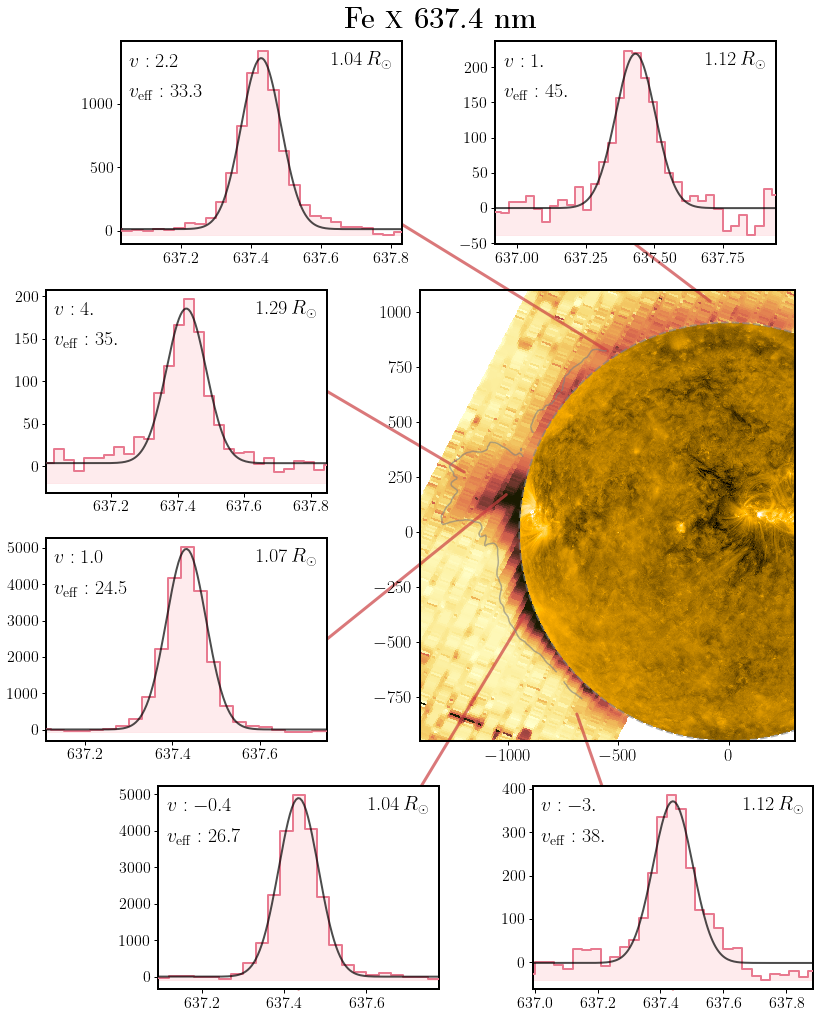

In [88]:
colorbar_width = "5%"

fig, ax = plt.subplots(figsize=(8,8),constrained_layout=True,gridspec_kw={'left':0.4,'top':0.8,'bottom':0.2})

red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 940**2)
red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
red_line_int_masked[red_where_disk_ext] = np.nan
norm_red_line_int = ImageNormalize(red_line_int_masked,interval=ManualInterval(0,350),
                        stretch=SqrtStretch())

im = ax.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.1)

ax.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
        colors=['grey'])

norm_aia_171 = ImageNormalize(aia_171_image,interval=AsymmetricPercentileInterval(0.01,99.99),stretch=LogStretch())
ax.pcolormesh(aia_171_xcoord, aia_171_ycoord, aia_171_image,cmap=aia_171_cm,norm=norm_aia_171,
                rasterized=True,shading="auto")

# plot_colorbar(im, ax,width=colorbar_width)
xlim_zoomin = [-1400,300]
ylim_zoomin = [-950,1100]

ax.set_aspect(1)
# ax.add_patch(create_rec_eqs())
ax.add_patch(create_limb_circle(rsun_arcsec))
ax.set_xlim(xlim_zoomin)
ax.set_ylim(ylim_zoomin)
ax.tick_params(labelsize=18)

feed_params = (x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                        red_fit_filename_index, red_path,
                        totality_red_df_ext,FeX_xslice,flatfield_1d_FeX_52nd,52, 
                        red_fit_matrix_bin_ext, red_fit_matrix_bin_ext_err,
                        red_vlos_masked, red_vlos_masked_err, red_veff_masked, red_veff_masked_err)

spectral_line_zoom_in(-1009,169,fig,ax,[-1.0,0,0.75,0.45],(1,0.5),
                        *feed_params)
spectral_line_zoom_in(-1200,271,fig,ax,[-1.0,0.55,0.75,0.45],(1,0.5),
                        *feed_params)
spectral_line_zoom_in(-550,822,fig,ax,[-0.8,1.1,0.75,0.45],(1,0.1),
                        *feed_params)
spectral_line_zoom_in(-83,1047,fig,ax,[0.2,1.1,0.75,0.45],(0.5,0),
                        *feed_params)
spectral_line_zoom_in(-926,-378,fig,ax,[-0.7,-0.55,0.75,0.45],(0.5,0),
                        *feed_params)
spectral_line_zoom_in(-689,-827,fig,ax,[0.3,-0.55,0.75,0.45],(0.5,0),
                        *feed_params)
ax.text(-0.2,1.58,r"\textbf{Fe \textsc{x} 637.4 nm}",fontsize=30,transform=ax.transAxes)
fig.savefig(fname="../../slides/reg_meet/figs/FeX_zoomin.pdf",format="pdf",dpi=300,bbox_inches="tight")
fig.savefig(fname="../../slides/reg_meet/figs/FeX_zoomin.png",format="png",dpi=300,bbox_inches="tight")